In [1]:
%load_ext cudf.pandas

In [2]:
! pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [3]:
! pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
! pip3 install skypatrol

In [1]:
%pip install git+https://github.com/isadoranun/FATS@aa81ce7f68d137798126b6e425dd069c3b4fde3a

  Cloning https://github.com/isadoranun/FATS (to revision aa81ce7f68d137798126b6e425dd069c3b4fde3a) to c:\users\lilu\appdata\local\temp\pip-req-build-htehup10
  Resolved https://github.com/isadoranun/FATS to commit aa81ce7f68d137798126b6e425dd069c3b4fde3a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\lilu\appdata\local\programs\python\python312\lib\site-packages\fats-1.3.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Running command git clone --filter=blob:none --quiet https://github.com/isadoranun/FATS 'C:\Users\Lilu\AppData\Local\Temp\pip-req-build-htehup10'
  Running command git rev-parse -q --verify 'sha^aa81ce7f68d137798126b6e425dd069c3b4fde3a'
  Running command git fetch -q https://github.com/isadoranun/FATS aa81ce7f68d137798126b6e425dd069c3b4fde3a
  Running command git checkout -q aa81ce7f68d137798126b6e425dd069c3b4fde3a


In [117]:
import csv
import datetime
import io
import os
import pickle
from warnings import filterwarnings

import boto3

import FATS
import keras.metrics
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    MaxPooling1D,
    Flatten
)
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Sequential



In [ ]:
filterwarnings('ignore', category=RuntimeWarning)

Загрузка данных

In [17]:
! aws configure
s3 = boto3.client('s3', endpoint_url='https://storage.yandexcloud.net')
bucket_name = 'guard-01'
response= s3.list_objects_v2(Bucket=bucket_name, Delimiter='/')

output_csv = "filenames.csv"
with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    folders = [prefix['Prefix'] for prefix in response.get('CommonPrefixes', [])]
    for folder in folders[2:]:
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=folder)
        objects = []

        n_objects = 0
        for i, page in enumerate(pages):
            if 'Contents' in page:
                if i % 50 == 0:
                    print(f"Page {i}. {n_objects} items processed.")
                n_objects += len(page['Contents'])
                for obj in page['Contents']:
                    if obj['Key'].endswith(".csv"):
                        writer.writerow(obj['Key'].split('/')[1:])

AWS Access Key ID [None]: YCAJEwlvD7seR1kGiUHgc2XX3
AWS Secret Access Key [None]: YCNMNFBWv2qBOkFJgoCsF-54lcmi00XI6PtjRMmG
Default region name [None]: ru-cental1-a
Default output format [None]: 
Page 0. 0 items processed.
Page 50. 50000 items processed.
Page 100. 100000 items processed.
Page 150. 150000 items processed.
Page 200. 200000 items processed.
Page 250. 250000 items processed.
Page 300. 300000 items processed.
Page 350. 350000 items processed.
Page 400. 400000 items processed.
Page 450. 450000 items processed.
Page 500. 500000 items processed.
Page 550. 550000 items processed.
Page 600. 600000 items processed.
Page 650. 650000 items processed.
Page 700. 700000 items processed.
Page 750. 750000 items processed.
Page 800. 800000 items processed.
Page 850. 850000 items processed.
Page 900. 900000 items processed.
Page 950. 950000 items processed.
Page 1000. 1000000 items processed.
Page 1050. 1050000 items processed.
Page 1100. 1100000 items processed.
Page 1150. 1150000 items p

In [ ]:
os.chdir('classificaton_var_stars')

In [ ]:
df = pd.read_csv('data\\filenames.csv', header=None)
df.columns = ['main_class', 'asas_sn_id']
df['asas_sn_id'] = df['asas_sn_id'].apply(lambda x: x.split('.')[0])
df = df[['asas_sn_id', 'main_class']]
df

,asas_sn_id,main_class
0,1002395,ECLIPSING
1,1003202,ECLIPSING
2,1003959,ECLIPSING
3,1004036,ECLIPSING
4,100590,ECLIPSING
...,...,...
1494795,661428625363,xray
1494796,661428693462,xray
1494797,661428895304,xray
1494798,8590170053,xray


In [6]:
df['main_class'].value_counts()

main_class
ECLIPSING      578603
PULSATING      453156
ROTATING       434944
ERUPTIVE        13477
cataclysmic      8582
OTHERS           6000
xray               38
Name: count, dtype: int64

In [7]:
from pyasassn.client import SkyPatrolClient
client = SkyPatrolClient()
client.catalogs.aavsovsx

Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.17 (26 JAN 2024)
Please upgrade your client if not up to date.



,col_names,dtypes
0,asas_sn_id,bigint
1,ra_deg,double
2,dec_deg,double
3,source_number,bigint
4,name,string
5,variability_flag,bigint
6,lii,double
7,bii,double
8,variability_type,string
9,max_mag_type,double


In [8]:
Var_dict = {
    'ECLIPSING':['E','EA','EB','E-DO','EP','EW','EC','ED','ESD','AR','BD','D','DM','DS','DW','EL','GS','HW','K','KE','KW','PN','SD','WD'],
    'ROTATING': ['ACV','BY','CTTS','ROT','INT','IT','ELL','FKCOM','HB','LERI','PSR','R','ROT','RS','SXARI','SXARI','E','TTS','ROT','WTTS','ROT','NSIN', 'ELL','PSR','ROT','RS'],
    'PULSATING':['ACEP', 'ACEP(B)', 'ACEPS', 'ACYG', 'BCEP', 'BCEPS', 'BLAP', 'BXCIR', 'CEP', 'CW', 'CWA', 'CWB', 'CWB(B)', 'CWBS', 'DCEP', 'DCEP(B)', 'CEP(B)', 'DCEPS', 'DCEPS(B)', 'DSCT', 'DSCTC', 'DWLYN', 'GDOR', 'HADS', 'HADS(B)', 'L', 'LB', 'LC', 'M', 'ORG', 'PPN', 'PVTEL', 'PVTELI', 'PVTELII', 'PVTELIII', 'roAm', 'roAp', 'ACVO', 'RR', 'RRAB', 'RRC', 'RRD', 'RR(B)', 'RV', 'RVA', 'RVB', 'SPB', 'LPB', 'SPBe', 'SR', 'SRA', 'SRB', 'SRC', 'SRD', 'SRS', 'SXPHE', 'SXPHE(B)', 'V361HYA', 'RPHS', 'V1093HER', 'ZZ', 'ZZA', 'ZZB', 'ZZ/GWLIB', 'ZZO', 'ZZLep', 'LPV', 'CW-FO', 'CW-FU', 'DCEP-FO', 'DCEP-FU', 'DSCTr', 'PULS', '(B)', 'BL', 'GWLIB', 'O'],
    'ERUPTIVE':['BE', 'cPNB[e]', 'CTTS', 'DPV', 'DYPer', 'EXOR', 'FF', 'FSCMa', 'FUOR', 'FU', 'GCAS', 'I', 'IA', 'IB', 'IN', 'INA', 'INAT', 'INB', 'INS', 'INSA', 'INSB', 'INST', 'INT', 'IS', 'ISA', 'ISB', 'RCB', 'SDOR', 'TTS', 'UV', 'UVN', 'UXOR', 'WR', 'WTTS', 'ZZA/O', 'YSO', 'DIP', 'WR', '(YY)'],
    'CATACLYSMIC':['AM', 'CBSS', 'CBSS/V', 'DQ', 'DQ/AE', 'IBWD', 'N', 'NA', 'NB', 'NC', 'NL', 'NL/VY', 'NR', 'SN', 'SN I', 'SN Ia', 'SN Iax', 'SN Ia-00cx-like', 'SN Ia-02es-like', 'SN Ia-06gz-like', 'SN Ia-86G-like', 'SN Ia-91bg-like', 'SN Ia-91T-like', 'SN Ia-99aa-like', 'SN Ia-Ca-rich', 'SN Ia-CSM', 'SN Ib', 'SN Ic', 'SN Icn', 'SN Ic-BL', 'SN Idn', 'SN Ien', 'SN II', 'SN IIa', 'SN IIb', 'SN IId', 'SN II-L', 'SN IIn', 'SN II-P', 'SN-pec', 'SLSN', 'SLSN-I', 'SLSN-II', 'UG', 'UGER', 'UGSS', 'UGSU', 'UGWZ', 'UGZ', 'UGZ/IW', 'V838MON', 'WDP', 'ZAND', 'CV', 'IBWD', 'V', 'VY'],
    'XRAY':['HMXB', 'IMXB', 'LMXB', 'X', 'BHXB', 'XB', 'XJ', 'XN', 'XP', 'XPR', 'XBR'],
    'others':['L:', 'S', '*'],
}

for key, value in Var_dict.items():
    value = tuple(value)
    query = f"""
    SELECT
    *
    FROM aavsovsx
    WHERE variability_type IN {value} and variability_flag=0
    ORDER BY asas_sn_id
    """
    df_name = f"df_{key.lower()}"
    globals()[df_name] = client.adql_query(query)[['asas_sn_id', 'variability_type']]
    print(f"Создана переменная: {df_name}")
#lcs2 = client.adql_query(query)
#eclip = lcs2[['asas_sn_id', 'variability_type']]
#eclip

Создана переменная: df_eclipsing
Создана переменная: df_rotating
Создана переменная: df_pulsating
Создана переменная: df_eruptive
Создана переменная: df_cataclysmic
Создана переменная: df_xray
Создана переменная: df_others


In [9]:
conc = pd.concat([df_eclipsing, df_rotating, df_pulsating, df_eruptive, df_cataclysmic,
           df_xray, df_others], axis=0)
conc.drop_duplicates(inplace=True)
conc

,asas_sn_id,variability_type
0,421,EW
1,2445,E
2,2546,EW
3,4618,EW
4,4998,EW
...,...,...
13585,661428965476,L:
13586,661428965524,L:
13587,661428965534,L:
13588,661428965590,L:


In [10]:
df['asas_sn_id'] = df['asas_sn_id'].astype('int64')
df.dtypes

asas_sn_id     int64
main_class    object
dtype: object

In [11]:
conc.duplicated().sum()

0

In [12]:
df_new = pd.merge(df, conc, on='asas_sn_id', how='inner')
df_new

,asas_sn_id,main_class,variability_type
0,1002395,ECLIPSING,EW
1,1003202,ECLIPSING,EW
2,1003959,ECLIPSING,EW
3,1004036,ECLIPSING,EW
4,100590,ECLIPSING,EA
...,...,...,...
1494798,661428625363,xray,HMXB
1494799,661428693462,xray,X
1494800,661428895304,xray,HMXB
1494801,8590170053,xray,HMXB


In [13]:
df_new['main_class'].value_counts()

main_class
ECLIPSING      578604
PULSATING      453157
ROTATING       434945
ERUPTIVE        13477
cataclysmic      8582
OTHERS           6000
xray               38
Name: count, dtype: int64

In [258]:
df_new.to_csv('id_mainclass_varclss.csv', index=False)

In [15]:
df_new.isna().sum()

asas_sn_id          0
main_class          0
variability_type    0
dtype: int64

In [16]:
classes_for_model = {"ECLIPSING": ["E", "EW", "EA", "EB"],
                    "PULSATING": ["SR", "RRAB", "SRS", "RRC", "L", "M",
                                "DSCT", "SRB", "HADS", "LB", "DCEP"],
                    "ROTATING": ["ROT", "ELL", "RS", "BY", "ACV"],
                    "ERUPTIVE": ["UV", "TTS", "GCAS"],
                    "cataclysmic": ["UG", "UGSU"]
                    }

In [17]:
# Создаем маску для фильтрации
mask = df_new.apply(
    lambda row: (
        row["main_class"] in classes_for_model  # Проверяем наличие класса в словаре
        and row["variability_type"] in classes_for_model[row["main_class"]]  # Проверяем тип
    ),
    axis=1
)

# Применяем маску
filtered_df = df_new[mask]

In [250]:
filtered_df

,asas_sn_id,main_class,variability_type
0,1002395,ECLIPSING,EW
1,1003202,ECLIPSING,EW
2,1003959,ECLIPSING,EW
3,1004036,ECLIPSING,EW
4,100590,ECLIPSING,EA
...,...,...,...
1494754,94489523523,cataclysmic,UGSU
1494756,94489954000,cataclysmic,UGSU
1494758,94490107581,cataclysmic,UG
1494759,94490226906,cataclysmic,UG


In [19]:
filtered_df['main_class'].value_counts()

main_class
ECLIPSING      482169
PULSATING      435981
ROTATING        94703
cataclysmic      6323
ERUPTIVE         3842
Name: count, dtype: int64

In [259]:
filtered_df.to_csv('id_mainclass_varclss_filtered.csv', index=False)

Балансировка - UNDERsampling всех подклассов

In [31]:
# Фильтрация данных

balance_strategies = {
            "ECLIPSING": {
                "under": {"E": 10000, "EW": 10000, "EA": 6000, "EB": 2000},
                "remain": {},
                "over": {}
            },
            "PULSATING": {
                "under": {"SR": 10000, "RRAB": 10000, "SRS": 10000, "RRC": 5000,
                          "L": 5000, "M": 4000, "DSCT": 2000, "SRB": 1000,
                          "HADS": 1000, "LB": 1000, "DCEP": 1000},
                "remain": {},
                "over": {}
            },
            "ROTATING": {
                "under": {"ROT": 6000, "ELL": 4000},
                "remain": {"RS": 2000, "BY": 1000, "ACV": 1000},
                "over": {}
            },
            "ERUPTIVE": {
                "under": {},
                "remain": {"UV": 1000, "TTS": 1000},
                "over": {"GCAS": 1000}
            },
            "cataclysmic": {
                "under": {},
                "remain": {"UG": 2000},
                "over": {"UGSU": 1000}
            }
            }

balanced_ids = []

for main_class, strategies in balance_strategies.items():
    class_data = filtered_df[filtered_df["main_class"] == main_class]

    for strategy, subcl in strategies.items():
        if strategy == 'under':
            for sub, target in subcl.items():
                subclass_data = class_data[class_data["variability_type"] == sub]
                subclass_data = resample(subclass_data, n_samples=target, random_state=42, replace=False)
                balanced_ids.extend(subclass_data["asas_sn_id"].tolist())
        else:
            for sub, target in subcl.items():
                subclass_data = class_data[class_data["variability_type"] == sub]
                balanced_ids.extend(subclass_data["asas_sn_id"].tolist())

balanced_labels = filtered_df[filtered_df["asas_sn_id"].isin(balanced_ids)]

In [32]:
# до
filtered_df.groupby(['main_class','variability_type']).count()

asas_sn_id
main_class  variability_type            
ECLIPSING   E                     338364
            EA                     49312
            EB                     11260
            EW                     83233
ERUPTIVE    GCAS                     942
            TTS                     1055
            UV                      1845
PULSATING   DCEP                    2277
            DSCT                    5972
            HADS                    2585
            L                      33486
            LB                      2470
            M                      20380
            RRAB                   90026
            RRC                    34751
            SR                    166584
            SRB                     3540
            SRS                    73910
ROTATING    ACV                     1397
            BY                      3393
            ELL                    25436
            ROT                    59419
            RS                      5058
cataclysmic UG                      5523
            UGSU                     800

In [47]:
# после
balanced_labels.groupby(['main_class','variability_type']).count()

asas_sn_id
main_class  variability_type            
ECLIPSING   E                      10000
            EA                      6000
            EB                      2000
            EW                     10000
ERUPTIVE    GCAS                     942
            TTS                     1055
            UV                      1845
PULSATING   DCEP                    1000
            DSCT                    2000
            HADS                    1000
            L                       5000
            LB                      1000
            M                       4000
            RRAB                   10000
            RRC                     5000
            SR                     10000
            SRB                     1000
            SRS                    10000
ROTATING    ACV                     1397
            BY                      3393
            ELL                     4000
            ROT                     6000
            RS                      5058
cataclysmic UG                      5523
            UGSU                     800

In [48]:
balanced_labels.groupby(['main_class']).count()

,asas_sn_id,variability_type
main_class,,
ECLIPSING,28000,28000
ERUPTIVE,3842,3842
PULSATING,50000,50000
ROTATING,19848,19848
cataclysmic,6323,6323


In [ ]:
balanced_labels.to_csv('data\\balanced_labels_100thsd.csv', index=False)

Объединенная подготовка для извлечения FATS признаков и подготовка данных для CNN

In [ ]:
class S3TimeSeriesProcessor:
    """Processes astronomical time series data from S3 storage for different ML tasks.

    Handles CSV files containing light curve data, supporting:
    - Feature extraction for traditional ML
    - Data preparation for CNN models
    - Combined processing modes

    Args:
        bucket_name (str): Name of S3 bucket containing source data
        aws_access_key_id (str): AWS-compatible access key for S3 auth
        aws_secret_access_key (str): AWS-compatible secret key for S3 auth

    Attributes:
        s3 (boto3.client): Configured S3 client with Yandex Cloud endpoint
        bucket (str): Target bucket name for all operations
        scaler (StandardScaler): Scaler instance for data normalization

    Methods:
        process_prefix: Main processing method for S3 prefixes
        jd_to_mjd: Static method for Julian Day conversion
    """
    
    
    def __init__(self, bucket_name, aws_access_key_id, aws_secret_access_key):
        """Initializes S3 client and processing components."""
        self.s3 = boto3.client('s3',
                             aws_access_key_id=aws_access_key_id,
                             aws_secret_access_key=aws_secret_access_key,
                             endpoint_url='https://storage.yandexcloud.net')
        self.bucket = bucket_name
        self.scaler = StandardScaler()


    @staticmethod
    def jd_to_mjd(jd):
        """Converts Julian Day to Modified Julian Day (MJD).

        Args:
            jd (float): Julian Day value

        Returns:
            float: MJD value. Returns NaN for invalid inputs (negative/NaN JD).

        Formula:
            MJD = JD - 2,400,000.5
        """
        if np.isnan(jd) or jd < 0:
            return np.nan
        return jd - 2400000.5


    def _process_file(self, file_key, processing_type, max_length=100):
        """Internal method for processing individual S3 files.

        Args:
            file_key (str): Full S3 object key/path
            processing_type (str): Processing mode - 'features', 'cnn', or 'both'
            max_length (int): Sequence length for CNN padding (default: 100)

        Returns:
            varies: Based on processing_type:
                - 'features': pandas.DataFrame with extracted features
                - 'cnn': numpy.ndarray of shaped (max_length, 2)
                - 'both': dict with 'features' and 'cnn_data' keys
                - None for invalid files/processing errors

        Note:
            - Performs common preprocessing: NaN removal, JD->MJD conversion
            - Requires CSV format with header row and columns: mag, jd, mag_err
            - Skips files with <10 valid observations after preprocessing
        """
        try:
            # Загрузка и базовый препроцессинг
            response = self.s3.get_object(Bucket=self.bucket, Key=file_key)
            content = response['Body'].read().decode('utf-8')
            
            df = pd.read_csv(io.StringIO(content), header=1)
            
            # Принудительное преобразование типов
            required_cols = {'mag', 'jd', 'mag_err'}
            for col in required_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Общая предобработка
            df = df[['mag', 'jd', 'mag_err']].dropna(how='any', axis=0).\
                                              drop_duplicates(subset='jd')

            mask = (
                np.isfinite(df['mag']) &
                np.isfinite(df['jd']) &
                np.isfinite(df['mag_err'])
            )
            df = df[mask].copy()
            if df.empty:
                return None, None

            df.loc[:, 'jd'] = df.loc[:, 'jd'].apply(self.jd_to_mjd)
            df = df.dropna(subset=['jd'], how='any').sort_values('jd')
            
            # Удаление выбросов
            mean_mag_err = df['mag_err'].mean()
            mask_err = (df['mag_err'] < 3 * mean_mag_err)

            mean_mag = df['mag'].mean()
            std_mag = df['mag'].std()
            if std_mag == 0:
                mask_mag = pd.Series(True, index=df.index)
            else:
                mask_mag = ((np.abs(df['mag'] - mean_mag) / std_mag) < 5)

            df = df[mask_err & mask_mag].copy()

            # Если слишком мало данных в файле
            if len(df) < 100:
                return None, None

            # Разделение обработки
            if processing_type == 'features':
                return self._extract_features(df, file_key)

            elif processing_type == 'cnn':
                return self._prepare_cnn_data(df, max_length)

            elif processing_type == 'both':
                features = self._extract_features(df, file_key, return_df=True)
                cnn_data = self._prepare_cnn_data(df, max_length)
                return {**(features if features is not None else {}), 'cnn_data': cnn_data}

        except Exception as e:
            print(f"Error processing {file_key}: {str(e)}")
            return None, None


    def _extract_features(self, df, file_key, return_df=False):
        """Internal feature extraction using FATS library.

        Args:
            df (pd.DataFrame): Preprocessed light curve data
            file_key (str): Source file path for ID extraction
            return_df (bool): Whether to return raw data (default: False)

        Returns:
            pd.DataFrame/None: Features DataFrame, or None on failure
            dict/None: If return_df=True, adds raw data arrays under 'raw_data'

        Note:
            Computes 17 statistical features using FATS library
            Object ID is extracted from filename (basename without extension)
        """
        try:
            mag = df['mag'].values
            time = df['jd'].values
            error = df['mag_err'].values

            #preprocessed_data = FATS.Preprocess_LC(mag, time, error)
            #mag, time, error = preprocessed_data.Preprocess()

            features = FATS.FeatureSpace(
                featureList=['Amplitude','Mean','Std','Skew','MedianAbsDev'
                                ,'PeriodLS','Period_fit','Freq1_harmonics_amplitude_0',
                                'FluxPercentileRatioMid20','FluxPercentileRatioMid80',
                                'PercentAmplitude','LinearTrend','MaxSlope',
                                'SlottedA_length','StructureFunction_index_21',
                                'Autocor_length', 'StetsonK'],
                Data=['magnitude', 'time', 'error']
            ).calculateFeature(np.vstack([mag, time, error])).result(method='dict')

            file_id = file_key.split('/')[-1].split('.')[0]
            features_df = pd.DataFrame([features]).assign(object_id=file_id)

            return features_df if not return_df else {
                'features': features_df,
                'raw_data': (mag, time, error)
            }

        except Exception as e:
            #print(f"Feature extraction failed for {file_key}: {str(e)}")
            return None


    def _prepare_cnn_data(self, df, max_length):
        """Internal method for CNN input preparation.

        Args:
            df (pd.DataFrame): Preprocessed light curve data
            max_length (int): Target sequence length

        Returns:
            numpy.ndarray: Shaped (max_length, 2) array containing:
                - StandardScaler-normalized [mag, mag_err] values
                - Zero-padded if shorter than max_length
                - Truncated if longer than max_length
        """
        try:
            scaled = self.scaler.fit_transform(df[['mag', 'mag_err']])

            if len(scaled) > max_length:
                padded = scaled[:max_length]
            else:
                padded = np.pad(scaled,
                            ((0, max_length - len(scaled)), (0, 0)),
                            mode='constant',
                            constant_values=0)
                
            # Проверка окончательной формы
            if padded.shape != (max_length, 2):
                print(f"Invalid shape after padding: {padded.shape}")
                return None
                
            return padded
        except Exception as e:
            print(f"Error in _prepare_cnn_data: {str(e)}")
            return None


    def process_prefix(self, prefix, ids_list, processing_type='both', max_length=100):
        """Processes all files in S3 prefix matching object IDs.

        Args:
            prefix (str): S3 prefix (folder path) to process
            ids_list (list[int]): List of numeric object IDs to include
            processing_type (str): One of ['features', 'cnn', 'both'] (default: 'both')
            max_length (int): Padding length for CNN data (default: 100)

        Returns:
            tuple: (features_df, cnn_data) where:
                - features_df: pandas.DataFrame of extracted features (None if empty)
                - cnn_data: numpy.ndarray of shaped (n_samples, max_length, 2) (None if empty)

        Note:
            - Saves results to S3 automatically:
                - Features: {prefix}/features.csv
                - CNN data: {prefix}/cnn_data.npz
            - Uses pagination to handle large prefix contents
            - Processes ~50 files before printing progress update
            - Skips files with invalid formats/non-numeric names
        """
        features_df = pd.DataFrame()
        cnn_data = []
        ids = []
        i=0

        try:
            paginator = self.s3.get_paginator('list_objects_v2')
            page_iterator = paginator.paginate(Bucket=self.bucket, Prefix=prefix)

            for page in page_iterator:
                if 'Contents' not in page:
                    print(f"Префикс '{prefix}' не содержит объектов. Пропускаю...")
                    continue
                
                for obj in page['Contents']:
                    file_key = obj['Key']
                    if not file_key.endswith('.csv'):
                        continue

                    try:
                      file_id = int(file_key.split('/')[-1].split('.')[0])
                    except ValueError:
                      print(f"Skipping invalid file: {file_key}")
                      continue
                    if file_id not in ids_list:
                      continue

                    result = self._process_file(file_key, processing_type, max_length)
                    i+=1
                    if i % 100 == 0:
                      print(f"{i} items processed.")

                    if result is None:
                        continue

                    if processing_type == 'features':
                        features_df = pd.concat([features_df, result], ignore_index=True)
                    elif processing_type == 'cnn':
                        if isinstance(result, np.ndarray) and result.shape == (max_length, 2):
                            cnn_data.append(result)
                            ids.append(str(file_id))
                    elif processing_type == 'both':
                        if 'features' not in result or 'cnn_data' not in result:
                            continue
                        if result['cnn_data'].shape == (max_length, 2):
                            features_df = pd.concat([features_df, result['features']], ignore_index=True)
                            cnn_data.append(result['cnn_data'])
                            ids.append(str(file_id))


            # Сохранение результатов
            if processing_type in ['features', 'both'] and not features_df.empty:
                csv_buffer = io.StringIO()
                features_df.to_csv(csv_buffer, index=False)
                self.s3.put_object(
                    Bucket=self.bucket,
                    Key=f"{prefix}/features_100thsnd.csv",
                    Body=csv_buffer.getvalue()
                )

            if processing_type in ['cnn', 'both'] and cnn_data:
                with io.BytesIO() as buffer:
                    np.savez(buffer,
                            X=np.array(cnn_data),
                            ids=np.array(ids))
                    buffer.seek(0)
                    self.s3.put_object(
                        Bucket=self.bucket,
                        Key=f"{prefix}/cnn_data_100thsnd.npz",
                        Body=buffer.getvalue()
                    )
                    
            print(f'Результат {prefix} сохранен')
            
        except Exception as e:
            print(f"Ошибка при обработке префикса {prefix, file_key}: {str(e)}")

        features_result = features_df if not features_df.empty else None
        cnn_result = np.array(cnn_data) if cnn_data else None
        return (features_result, cnn_result)



# Варианты обработки:
#processor = S3TimeSeriesProcessor('your-bucket-name', aws_access_key_id, aws_secret_access_key)
# 1. Только фичи
#features_df, _ = processor.process_prefix('raw_data/', ids, processing_type='features')
# 2. Только данные для CNN
#_, cnn_data = processor.process_prefix('raw_data/', ids, processing_type='cnn')
# 3. Оба варианта одновременно
#full_features, full_cnn = processor.process_prefix('raw_data/', ids, processing_type='both')

In [ ]:
# Настройки S3
#aws_access_key_id = os.getenv('aws_access_key_id')
#aws_secret_access_key = os.getenv('aws_secret_access_key')
S3_BUCKET = 'guard-01'

In [ ]:
# Основной процесс выполнения
prefixs = ['variables/ECLIPSING/', 'variables/ERUPTIVE/',
           'variables/PULSATING/', 'variables/ROTATING/',
          'variables/cataclysmic/']
          

processor = S3TimeSeriesProcessor(S3_BUCKET,
                                  aws_access_key_id,
                                  aws_secret_access_key)

for pref in prefixs:
    ids_label = pref.split('/')[1]
    ids = balanced_labels[balanced_labels['main_class'] == ids_label]\
                                        ['asas_sn_id'].values.tolist()
    
    df_name = f"df_{pref.replace('/', '_')}"
    try:
      features, cnn = processor.process_prefix(pref,
                                                ids_list=ids,
                                                processing_type='cnn',
                                                max_length=500)

      if features is not None and not features.empty:
        print(f"Обработано объектов: {len(features)}")

      if cnn is not None:
        print(f"CNN данных: {cnn.shape}")
    except Exception as e:
        print(f"Ошибка при обработке папки {pref}: {str(e)}")

Иерархическая модель CNN

In [3]:
# Загрузка NPZ-файлов
categories = ['cataclysmic', 'ECLIPSING', 'ERUPTIVE', 
              'PULSATING', 'ROTATING']
for category in categories:
    file_path = f'data\\{category}cnn_data_100thsnd.npz'
    npz_data = np.load(file_path)
    globals()[f'{category}_ts_data'] = npz_data

In [4]:
# Инициализируем пустые списки для накопления данных
X_list = []
ids_list = []
for category in categories:
    X = globals()[f'{category}_ts_data']['X']
    ids = globals()[f'{category}_ts_data']['ids']
    X_list.append(X)
    ids_list.append(ids)
    
# Объединяем все данные
X_ts_combined = np.concatenate(X_list, axis=0)  # shape: (Total_samples, 100, 2)
ids_ts_combined = np.concatenate(ids_list, axis=0)  # shape: (Total_samples,)

In [5]:
print(X_ts_combined.shape)
print(ids_ts_combined.shape)

(108011, 500, 2)
(108011,)


In [6]:
labels_df = pd.DataFrame(data=ids_ts_combined.tolist(), columns=['ids'])
labels_df['ids'] = labels_df['ids'].astype('int64')
labels_df


,ids
0,103079304553
1,103079638041
2,103079712924
3,103079720827
4,103079869726
...,...
108006,94490758586
108007,94490777752
108008,94490785181
108009,94490798093


In [67]:
# Создаем случайное перемешивание по индексам
n_samples = len(labels_df)
rng = np.random.default_rng(seed=42) 
shuffled_indices = rng.permutation(n_samples)

labels_df = labels_df.iloc[shuffled_indices].reset_index(drop=True)
X_ts_combined = X_ts_combined[shuffled_indices]
ids_ts_combined = ids_ts_combined[shuffled_indices]

# Проверка результата
print("Первые 5 ID после перемешивания:")
print("DataFrame IDs:", labels_df['ids'].head().values)
print("NPZ IDs:", ids_ts_combined[:5])

Первые 5 ID после перемешивания:
DataFrame IDs: [412316911886 661428092669 661428788196 661428867507 661427957842]
NPZ IDs: ['412316911886' '661428092669' '661428788196' '661428867507'
 '661427957842']


In [119]:
combined_features_tempdf = pd.merge(labels_df, balanced_labels, 
                                    left_on='ids', right_on='asas_sn_id', 
                                    how='left').drop(columns=['ids'])
combined_features_tempdf.head(5)

,asas_sn_id,main_class,variability_type
0,231929132203,PULSATING,M
1,352187928377,PULSATING,RRC
2,240518360969,PULSATING,RRAB
3,661428185477,ECLIPSING,E
4,661428269393,PULSATING,RRAB


In [120]:
y_labels = combined_features_tempdf[['asas_sn_id', 
                                     'main_class', 
                                     'variability_type']]

In [ ]:
# Сохраним полученные объединенные признаки и целевые переменные
y_labels.to_csv('data\\y_labels100.csv', index=False)
print(f"CSV сохранен: data\\y_labels100.csv ({len(y_labels)} строк)")

# Сохранение перемешанных NPZ
np.savez(
    'data\\shuffled_combined100.npz',
    X=X_ts_combined,
    ids=ids_ts_combined
)
print("NPZ сохранен: data\\shuffled_combined100.npz")

CSV сохранен: y_labels100.csv (108011 строк)
NPZ сохранен: shuffled_combined100.npz


In [72]:
# Подготовка данных для модели
y_labels = pd.read_csv('data\\y_labels100.csv')

cnn_arrays = np.load('data\\shuffled_combined100.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [73]:
X_ts.shape

(108011, 500, 2)

In [ ]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
ohe_sub = OneHotEncoder(sparse_output=False)

In [75]:
def build_supervised_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu',
               padding='same', input_shape=input_shape),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        GlobalMaxPooling1D(),
        Dense(256, activation='relu', name="embeddings"), # Слой для эмбеддингов
        Dense(num_classes, activation='softmax')
    ])
    return model

In [76]:
# input_shape с 2 каналами
input_shape = (X_ts.shape[1], X_ts.shape[2])
input_shape

(500, 2)

In [77]:
class F1Macro(Metric):
    def __init__(self, name='f1_macro', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.argmax(y_true, axis=1)
        y_pred = K.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + K.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [129]:
# Создаем и компилируем модель
num_main_classes = len(['ECLIPSING', 'ERUPTIVE', 'PULSATING', 'ROTATING', 'cataclysmic'])
cnn_model = build_supervised_cnn(input_shape, num_main_classes)
cnn_model.compile(
    optimizer='nadam',
    loss='categorical_crossentropy',
    metrics= [F1Macro()]
)

c:\Users\Lilu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=True,
                                                      update_freq='epoch',
                                                      profile_batch=0
                                                      )


In [ ]:
# Вычисление весов классов до SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.7715071428571428,
 1: 5.622644456012494,
 2: 0.432044,
 3: 1.0884913836541368,
 4: 3.416447888660446}

In [101]:
# Извлекаем сырые текстовые метки для основного класса
y_main_labels = y_labels['main_class']

# Ручное разделение на тренировочную и валидационную выборки (20% валидация)
X_train, X_val, y_train, y_val = train_test_split(
    X_ts, 
    y_main_labels, 
    test_size=0.2, 
    stratify=y_main_labels,  # Сохраняем распределение классов
    random_state=42
)

# Преобразуем 3D данные в 2D для SMOTE
n_samples, timesteps, features = X_train.shape
X_train_flat = X_train.reshape(n_samples, -1)

# Применяем SMOTE
smote = SMOTE(
    sampling_strategy={
        'ECLIPSING': 28000,
        'ERUPTIVE': 10000,
        'PULSATING': 50000,# Создать 500 образцов для этого класса
        'ROTATING': 19846,
        'cataclysmic': 10000
    },   
    random_state=42,
    k_neighbors=3)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Восстанавливаем 3D структуру
X_train_resampled = X_train_resampled_flat.reshape(-1, timesteps, features)

# Кодируем метки после SMOTE в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train_resampled, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [ ]:
# Вычисление весов классов после SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_train_resampled
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.8417571428571429,
 1: 2.35692,
 2: 0.471384,
 3: 1.1876045550740704,
 4: 2.35692}

In [ ]:
history = cnn_model.fit(
    X_train_resampled, 
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val_onehot),
    callbacks=[
        tensorboard_callback,
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

In [103]:
# Найти индекс эпохи с минимальным val_loss
best_epoch = np.argmin(history.history['val_loss']) 

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,  # Эпохи нумеруются с 0
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_macro'][best_epoch], 
    'val_f1': history.history['val_f1_macro'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 3
Train F1: 0.8652
Train loss: 1.3758
Validation F1: 0.8511
Validation Loss: 1.3160


In [104]:
# Сохранение всей модели (архитектура + веса + оптимизатор)
cnn_model.save('data\\cnn_model_withSMOTE.keras') 

Оценка модели

In [95]:
def evaluate_hierarchical(y_true_main, y_true_sub, main_preds, sub_preds,
                          le_main, le_sub):
    """Generates classification reports for hierarchical main/sub-class predictions.

    Evaluates performance of a two-level hierarchical classification system by
    producing standardized metrics reports for both classification levels.

    Args:
        y_true_main (array-like): Encoded true labels for main classes
        y_true_sub (array-like): Encoded true labels for sub-classes
        main_preds (list[tuple]): Main level predictions as list of (label, confidence) tuples
        sub_preds (list[tuple]): Sub-level predictions as list of (label, confidence) tuples
        le_main (LabelEncoder): Trained LabelEncoder for main class labels
        le_sub (LabelEncoder): Trained LabelEncoder for sub-class labels

    Returns:
        tuple[dict, dict]: Two classification report dictionaries:
            - main_report: Metrics for main classes (precision/recall/F1)
            - sub_report: Metrics for sub-classes (precision/recall/F1)
    """
    # Преобразование числовых меток в оригинальные названия
    y_main_true_labels = le_main.inverse_transform(y_true_main)
    y_sub_true_labels = le_sub.inverse_transform(y_true_sub)

    # Извлечение предсказанных меток
    main_pred_labels = [pred[0] for pred in main_preds]
    sub_pred_labels = [pred[0] for pred in sub_preds]

    # Сбор всех уникальных меток для корректного отображения в отчете
    all_main_labels = list(set(y_main_true_labels) | set(main_pred_labels))
    all_sub_labels = list(set(y_sub_true_labels) | set(sub_pred_labels))

    # Генерация отчетов
    print("\nMAIN CLASSES REPORT:")
    print(classification_report(
        y_main_true_labels,
        main_pred_labels,
        labels=all_main_labels,
        zero_division=0
    ))

    print("\nSUB CLASSES REPORT:")
    print(classification_report(
        y_sub_true_labels,
        sub_pred_labels,
        labels=all_sub_labels,
        zero_division=0
    ))

    # Возврат метрик в виде словарей
    main_report = classification_report(
        y_main_true_labels,
        main_pred_labels,
        labels=all_main_labels,
        output_dict=True,
        zero_division=0
    )

    sub_report = classification_report(
        y_sub_true_labels,
        sub_pred_labels,
        labels=all_sub_labels,
        output_dict=True,
        zero_division=0
    )

    return main_report, sub_report

Иерархическое предсказание с классом "другие"

In [96]:
def hierarchical_predict_with_proba(X, lgb_main, le_main,
                                    subclass_models, le_sub,
                                    MAIN_THRESHOLD, SUB_THRESHOLD):
    """Performs hierarchical classification with confidence-based fallback.

    Implements two-stage prediction with probabilistic thresholds:
    1. Main class prediction with 'OTHER' fallback
    2. Subclass prediction conditioned on main class results

    Args:
        X (array-like): Input features array of shape (n_samples, n_features)
        lgb_main (LGBMClassifier): Trained LightGBM model for main classes
        le_main (LabelEncoder): LabelEncoder for main class labels
        subclass_models (dict): Dictionary mapping {main_label: sub_model} 
            where sub_model is trained on corresponding subclasses
        le_sub (LabelEncoder): LabelEncoder for all possible subclass labels
        MAIN_THRESHOLD (float): Confidence threshold [0-1] for accepting main 
            class prediction (else 'OTHER')
        SUB_THRESHOLD (float): Confidence threshold [0-1] for accepting subclass
            prediction (else 'CLASS_OTHER')

    Returns:
        tuple: 
            - main_results (list[tuple]): (predicted_label, confidence) for main classes
            - sub_results (list[tuple]): (predicted_label, confidence) for subclasses

    Note:
        - 'OTHER' handling:
            - Main level: Used when no class meets confidence threshold
            - Sub level: Used when either main is OTHER or subclass confidence is low
            - Subclass OTHER labels inherit parent class (e.g: 'CLASS_OTHER')
        - Confidence scores represent:
            - For accepted predictions: model's maximum class probability
            - For 'OTHER' predictions: 1 - max_prob (inverse confidence)
        - Subclass predictions only attempt if main class isn't OTHER and has a model
    """
    # Уровень 1: Основные классы
    main_proba = lgb_main.predict_proba(X)
    main_results = []

    for proba in main_proba:
        max_prob = np.max(proba)
        main_class_idx = np.argmax(proba)

        if max_prob > MAIN_THRESHOLD:
            main_label = le_main.classes_[main_class_idx]
            main_confidence = max_prob
        else:
            main_label = 'OTHER'
            main_confidence = 1 - max_prob  # Уверенность в "другости"

        main_results.append((main_label, main_confidence))

    # Уровень 2: Подклассы
    sub_results = []
    for i, (main_label, main_conf) in enumerate(main_results):
        if main_label == 'OTHER':
            sub_results.append(('OTHER', 1.0))  # 100% уверенности в OTHER для подкласса
            continue

        if main_label not in subclass_models:
            sub_label = f'{main_label}_OTHER'
            sub_results.append((sub_label, 1.0))
            continue

        model = subclass_models[main_label]
        sub_proba = model.predict_proba(X[i].reshape(1, -1))[0]
        max_sub_prob = np.max(sub_proba)
        sub_class_idx = np.argmax(sub_proba)

        if max_sub_prob > SUB_THRESHOLD:
            sub_label = le_sub.classes_[sub_class_idx]
            sub_confidence = max_sub_prob
        else:
            sub_label = f'{main_label}_OTHER'
            sub_confidence = 1 - max_sub_prob

        sub_results.append((sub_label, sub_confidence))

    return main_results, sub_results


Иерархическая модель с объединением признаков (CNN + LightGBM)

In [97]:
categories = ['cataclysmic', 'ECLIPSING', 'ERUPTIVE', 
              'PULSATING', 'ROTATING', 'xray']

In [ ]:
# Загрузка обработанных данных после выполнения process_prefix
# Загрузка features-файлов
for category in categories:
    file_path = f'data\\{category}_features.csv'
    df_name = f'{category}_features_df'
    globals()[df_name] = pd.read_csv(file_path)

In [86]:
df_names = [f"{cat}_features_df" for cat in categories]
combined_features_df = pd.concat([globals()[name] for name in df_names], \
            axis=0, ignore_index=True)

In [94]:
combined_features_df.head(5)

,Amplitude,Mean,Std,Skew,MedianAbsDev,PeriodLS,Period_fit,Freq1_harmonics_amplitude_0,FluxPercentileRatioMid20,FluxPercentileRatioMid80,PercentAmplitude,LinearTrend,MaxSlope,SlottedA_length,StructureFunction_index_21,Autocor_length,StetsonK,object_id
0,1.530007,15.201498,0.857011,-1.399246,0.271658,1.022070,4.511439e-05,0.263962,0.066385,0.843146,0.186429,0.000085,126.956931,3.197048,1.284282,2.0,0.832573,120259959951
1,1.040945,17.824570,0.571469,-0.754466,0.392584,29.536625,2.663515e-58,0.481687,0.179300,0.769782,0.139044,0.000133,550.454183,4.002436,1.765901,2.0,0.111339,137440285998
2,1.091825,17.508822,0.633714,-0.285713,0.501566,29.528820,7.119716e-50,0.365998,0.210987,0.848659,0.163825,0.000017,625.283535,2.747352,2.103589,2.0,0.366133,17181269141
3,2.087583,15.599739,1.223183,-0.945798,0.545846,139.336016,3.674366e-06,0.348678,0.100774,0.866207,0.217138,-0.000138,1041.738146,2.840457,1.801837,2.0,0.860233,206158881929
4,1.070217,17.129456,0.568443,-0.660435,0.369684,0.499279,1.422515e-14,0.158430,0.151039,0.799771,0.133318,0.000031,491.409985,0.310282,1.552292,3.0,0.793622,231928754088


In [124]:
combined_features_df.shape

(9364, 18)

In [95]:
combined_features_df.isna().sum()

Amplitude                      0
Mean                           0
Std                            0
Skew                           0
MedianAbsDev                   0
PeriodLS                       0
Period_fit                     0
Freq1_harmonics_amplitude_0    0
FluxPercentileRatioMid20       0
FluxPercentileRatioMid80       0
PercentAmplitude               0
LinearTrend                    0
MaxSlope                       0
SlottedA_length                0
StructureFunction_index_21     0
Autocor_length                 0
StetsonK                       0
object_id                      0
dtype: int64

In [96]:
combined_features_df.duplicated().sum()

0

In [ ]:
# Загрузка NPZ-файлов
for category in categories:
    file_path = f'data\\{category}_cnn_data.npz'
    npz_data = np.load(file_path)
    globals()[f'{category}_ts_data'] = npz_data

In [ ]:
# Инициализируем пустые списки для накопления данных
X_list = []
ids_list = []
for category in categories:
    X = globals()[f'{category}_ts_data']['X']
    ids = globals()[f'{category}_ts_data']['ids']
    X_list.append(X)
    ids_list.append(ids)
    
# Объединяем все данные
X_ts_combined = np.concatenate(X_list, axis=0)  # shape: (Total_samples, 100, 2)
ids_ts_combined = np.concatenate(ids_list, axis=0)  # shape: (Total_samples,)

print(X_ts_combined.shape)
print(ids_ts_combined.shape)

In [ ]:
X_ts_combined[:,:,0].shape

In [ ]:
# Создаем случайное перемешивание по индексам
np.random.seed(42)
n_samples = len(combined_features_df)
shuffled_indices = np.random.permutation(n_samples)

combined_features_df = combined_features_df.iloc[shuffled_indices].reset_index(drop=True)
X_ts_combined = X_ts_combined[shuffled_indices]
ids_ts_combined = ids_ts_combined[shuffled_indices]

# Проверка результата
print("Первые 5 ID после перемешивания:")
print("DataFrame IDs:", combined_features_df['object_id'].head().values)
print("NPZ IDs:", ids_ts_combined[:5])

In [ ]:
# Добавим по индексам основные классы и подклассы
combined_features_df['object_id']

0       661427852331
1       266288991903
2       661427801040
3       661428558854
4       661428713332
            ...     
9359    661427842165
9360    609885944478
9361    661425145544
9362    369368396404
9363    661428444083
Name: object_id, Length: 9364, dtype: int64

In [ ]:
combined_features_tempdf = pd.merge(combined_features_df, balanced_labels, 
                                    left_on='object_id', right_on='asas_sn_id', 
                                    how='left').drop(columns=['object_id'])
combined_features_tempdf.head(5)

,Amplitude,Mean,Std,Skew,MedianAbsDev,PeriodLS,Period_fit,Freq1_harmonics_amplitude_0,FluxPercentileRatioMid20,FluxPercentileRatioMid80,PercentAmplitude,LinearTrend,MaxSlope,SlottedA_length,StructureFunction_index_21,Autocor_length,StetsonK,asas_sn_id,main_class,variability_type
0,0.599074,15.640474,0.368418,-0.973199,0.144847,18938.560898,2.740019e-120,3.912062,0.085856,0.923069,0.060127,0.000324,4.485750e+02,0.043879,1.471853,126.0,0.845719,661427852331,ECLIPSING,E
1,0.526554,13.319417,0.340474,-1.489534,0.054869,3785.577378,2.058097e-238,0.406253,0.041195,0.904477,0.074239,0.000263,9.568495e+02,0.098842,1.281370,252.0,0.792072,266288991903,PULSATING,SRS
2,182.069957,-38.204793,131.541023,-1.905834,1.189508,3781.999751,5.029911e-102,143.514869,0.007387,0.998525,22.500226,0.097375,2.043431e+03,0.096383,1.185204,112.0,0.392186,661427801040,ROTATING,ELL
3,1.099276,17.519183,0.575648,-0.747449,0.376794,29.543122,2.383366e-54,0.403434,0.161474,0.767327,0.134511,0.000097,5.216428e+02,0.626191,1.681907,2.0,0.304867,661428558854,ROTATING,ELL
4,0.425036,16.244193,0.214046,0.084165,0.139319,0.320380,1.549119e-37,0.104360,0.147033,0.769313,0.052530,0.000070,3.353625e+06,0.000001,1.630917,1.0,0.787059,661428713332,PULSATING,RRC


In [ ]:
y_labels = combined_features_tempdf[['asas_sn_id', 
                                     'main_class', 
                                     'variability_type']]

In [184]:
# Сохраним полученные объединенные признаки и целевые переменные
combined_features_df.to_csv('data\\shuffled_combined.csv', index=False)
print(f"CSV сохранен: data\\shuffled_combined.csv ({len(combined_features_df)} строк)")

y_labels.to_csv('data\\y_labels.csv', index=False)
print(f"CSV сохранен: data\\y_labels.csv ({len(y_labels)} строк)")

# Сохранение перемешанных NPZ
np.savez(
    'data\\shuffled_combined.npz',
    X=X_ts_combined,
    ids=ids_ts_combined
)
print("NPZ сохранен: data\\shuffled_combined.npz")

CSV сохранен: data\shuffled_combined.csv (9364 строк)
CSV сохранен: data\y_labels.csv (9364 строк)
NPZ сохранен: data\shuffled_combined.npz


In [7]:
# Подготовка данных для модели
features_df = pd.read_csv('data\\shuffled_combined.csv')
y_labels = pd.read_csv('data\\y_labels.csv')

cnn_arrays = np.load('data\\shuffled_combined.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [4]:
# Подготовка данных для модели
# Для FATS-фичей
scaler_fats = StandardScaler()
X_fats = scaler_fats.fit_transform(features_df.drop('object_id', axis=1))

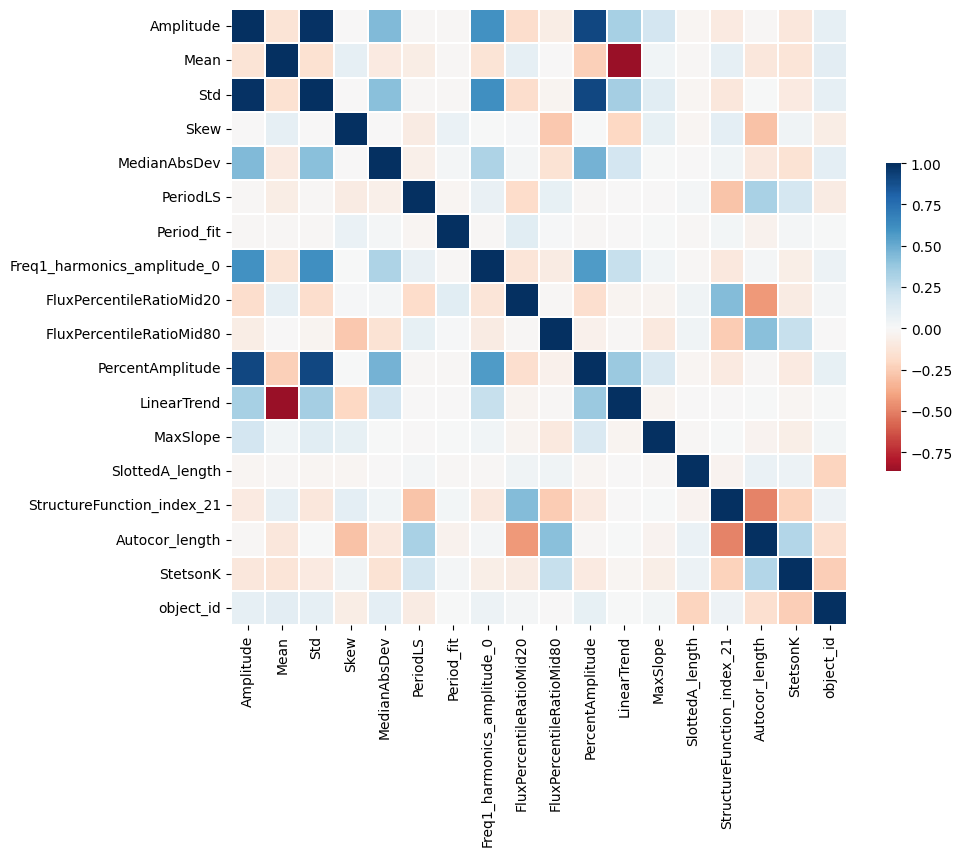

In [12]:
import seaborn as sns
corr = features_df.corr()


# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [ ]:
X_ts.shape

In [ ]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
ohe_sub = OneHotEncoder(sparse_output=False)
y_main = ohe_main.fit_transform(y_labels[['main_class']])
y_sub = ohe_sub.fit_transform(y_labels[['variability_type']])

In [ ]:
def build_supervised_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu',
               padding='same', input_shape=input_shape),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        GlobalMaxPooling1D(),
        Dense(256, activation='relu', name="embeddings"), # Слой для эмбеддингов
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# input_shape с 2 каналами
input_shape = (X_ts.shape[1], X_ts.shape[2])
input_shape

In [ ]:
# Создаем и компилируем модель
num_main_classes = len(['ECLIPSING', 'ERUPTIVE', 'PULSATING', 'ROTATING', 'cataclysmic'])
cnn_model = build_supervised_cnn(input_shape, num_main_classes)
cnn_model.compile(
    optimizer='nadam',
    loss='categorical_crossentropy',
    metrics= ['categorical_accuracy']
)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=True,
                                                      update_freq='epoch',
                                                      profile_batch=0
                                                      )

In [ ]:
# Вычисление весов классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

In [ ]:
# Обучение модели
history = cnn_model.fit(
    X_ts,
    y_main,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[
        tensorboard_callback,
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

In [ ]:
# Найти индекс эпохи с минимальным val_loss
best_epoch = np.argmin(history.history['val_loss']) 

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,  # Эпохи нумеруются с 0
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_macro'][best_epoch], 
    'val_f1': history.history['val_f1_macro'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

In [ ]:
plt.title('Training and Validation Loss', fontsize=14, pad=20)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14, labelpad=10)
plt.ylabel('Loss', fontsize=14, labelpad=10)

In [ ]:
# Сохранение всей модели (архитектура + веса + оптимизатор)
cnn_model.save('cnn_model.keras') 

In [303]:
# Извлечение эмбеддингов
X_ts_emb = cnn_model.predict(X_ts)

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [304]:
# Объединение признаков и иерархическая классификация
# Объединение FATS и эмбеддингов
X_combined = np.concatenate([X_fats, X_ts_emb], axis=1)

In [305]:
# Разделение на тренировочные и тестовые данные
X_train, X_test, y_main_train, y_main_test, y_sub_train, y_sub_test = train_test_split(
    X_combined, y_main, y_sub, test_size=0.2, stratify=y_main, random_state=42
)

In [318]:
# Иерархическая модель LightGBM
# Уровень 1: Классификация основных классов
lgb_main = lgb.LGBMClassifier(
    num_leaves=64,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=300,
    class_weight='balanced'
)
lgb_main.fit(X_train, y_main_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7491, number of used features: 17
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=300,
               num_leaves=64)

In [ ]:
# Уровень 2: Классификация подклассов внутри каждого основного класса
subclass_models = {}
for main_class in np.unique(y_main):
    # Фильтрация данных по основному классу
    mask = y_main_train == main_class
    X_sub_train = X_train[mask]
    y_sub_train_filtered = y_sub_train[mask]

    # Обучение LightGBM для подклассов
    lgb_sub = lgb.LGBMClassifier(
        num_leaves=32,
        learning_rate=0.1,
        n_estimators=200,
        class_weight='balanced'
    )
    lgb_sub.fit(X_sub_train, y_sub_train_filtered)
    subclass_models[main_class] = lgb_sub

In [ ]:
# Сохранение LightGBM моделей
model_artifacts = {
    'lgb_main': lgb_main,
    'subclass_models': subclass_models
}

with open('lightgbm_models.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

In [ ]:
# Сохранение препроцессоров
preprocessors = {
    'le_main': le_main,
    'le_sub': le_sub,
    'scaler_fats': scaler_fats
}

with open('preprocessors.pkl', 'wb') as f:
    pickle.dump(preprocessors, f)

In [ ]:
main_preds, sub_preds = hierarchical_predict_with_proba(X_test, lgb_main, le_main,
                                                        subclass_models, le_sub,
                                                        MAIN_THRESHOLD=0.7,
                                                        SUB_THRESHOLD=0.7)

In [ ]:
# Преобразование меток для оценки
main_label, main_prob = main_preds[0]
sub_label, sub_prob = sub_preds[0]

In [ ]:
# Оценка
main_report, sub_report = evaluate_hierarchical(
    y_main_test,
    y_sub_test,
    main_preds,
    sub_preds,
    le_main,
    le_sub
)